Starting team conversation monitoring system...
This system will analyze speech emotions and sentiments in real-time.
Press Ctrl+C to stop the monitoring.

Error: RealtimeSpeechSentimentDetector() takes no arguments


Applying noise reduction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


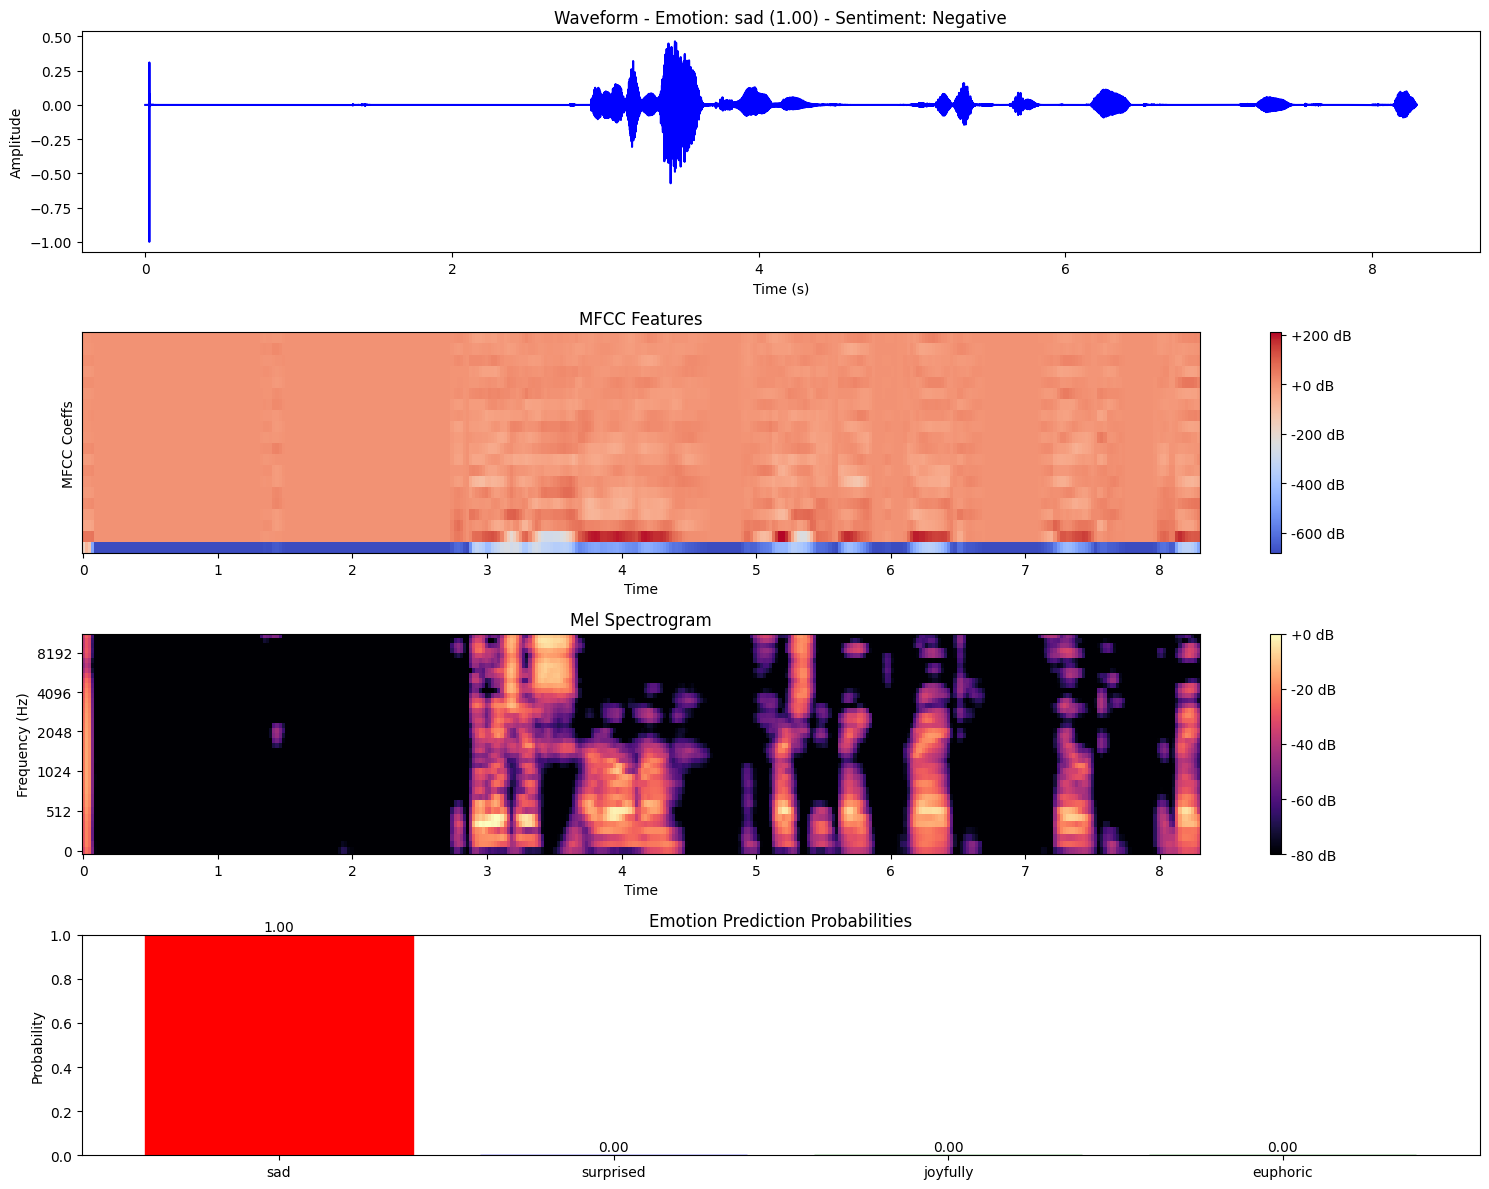

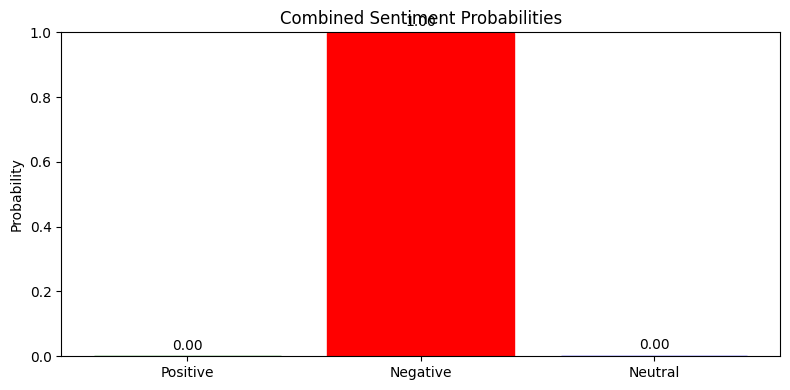

Predicted emotion: sad
Sentiment category: Negative
Confidence: 1.00

All probabilities:
  sad: 1.00
  surprised: 0.00
  joyfully: 0.00
  euphoric: 0.00

Sentiment probabilities:
  Positive: 0.00
  Negative: 1.00
  Neutral: 0.00


In [2]:
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import noisereduce as nr
import tempfile
import soundfile as sf

def reduce_noise(y, sr):
    """
    Reduces noise from an audio signal.
    
    Parameters:
    -----------
    y : numpy.ndarray
        Audio time series
    sr : int
        Sample rate of y
        
    Returns:
    --------
    y_denoised : numpy.ndarray
        Denoised audio time series
    """
    # Apply noise reduction
    y_denoised = nr.reduce_noise(y=y, sr=sr)
    
    # Normalize
    y_denoised = librosa.util.normalize(y_denoised)
    
    return y_denoised

def predict_emotion_with_sentiment(audio_file_path, model_path='speech_emotion_model_final_final.h5', show_plots=True):
    """
    Predict emotion from an audio file, map it to sentiment category, and visualize audio features.

    Parameters:
    -----------
    audio_file_path : str
        Path to the audio file to analyze
    model_path : str
        Path to the saved model file
    show_plots : bool
        Whether to display plots of audio features

    Returns:
    --------
    result : dict
        Dictionary containing:
        - emotion: The predicted emotion label
        - sentiment: The mapped sentiment category (Positive, Negative, Neutral)
        - confidence: Confidence score for the predicted emotion
        - all_probs: Dictionary with all emotion probabilities
        - sentiment_probs: Combined probabilities by sentiment category
    """
    # Define emotion labels (must match those used in training)
    emotion_labels = {
        'sad': 0,
        'surprised': 1,
        'joyfully': 2,
        'euphoric': 3
    }

    # Define sentiment mapping
    sentiment_mapping = {
        'sad': 'Negative',
        'surprised': 'Neutral',
        'joyfully': 'Positive',
        'euphoric': 'Positive'
    }

    # Reverse the dictionary for prediction output
    idx_to_emotion = {v: k for k, v in emotion_labels.items()}

    # Load the model
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    model = tf.keras.models.load_model(model_path)

    # Load and preprocess audio
    y, sr = librosa.load(audio_file_path, sr=22050)
    print("Applying noise reduction...")
    y = reduce_noise(y, sr)
    y = librosa.util.normalize(y)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)

    # Extract features
    mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=20, n_fft=2048, hop_length=512)
    mfccs_normalized = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / np.std(mfccs, axis=1, keepdims=True)

    mel_spec = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=40, n_fft=2048, hop_length=512, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_normalized = (mel_spec_db - np.mean(mel_spec_db)) / np.std(mel_spec_db)

    features = np.vstack([mfccs_normalized, mel_spec_normalized])

    # Apply same padding/cropping as in training
    max_pad_len = 150
    if features.shape[1] > max_pad_len:
        start = (features.shape[1] - max_pad_len) // 2
        features = features[:, start:start + max_pad_len]
    else:
        pad_width = max_pad_len - features.shape[1]
        features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant', constant_values=0)

    # Reshape features for the model
    features_for_model = features.reshape(1, features.shape[0], features.shape[1], 1)

    # Make prediction
    prediction = model.predict(features_for_model)[0]
    predicted_class = np.argmax(prediction)
    confidence = prediction[predicted_class]
    predicted_emotion = idx_to_emotion[predicted_class]

    # Map emotion to sentiment
    predicted_sentiment = sentiment_mapping[predicted_emotion]

    # Create dictionary with all emotion probabilities
    all_probs = {idx_to_emotion[i]: float(prob) for i, prob in enumerate(prediction)}

    # Calculate sentiment probabilities (combining emotions with the same sentiment)
    sentiment_probs = {
        'Positive': sum(all_probs[e] for e, s in sentiment_mapping.items() if s == 'Positive'),
        'Negative': sum(all_probs[e] for e, s in sentiment_mapping.items() if s == 'Negative'),
        'Neutral': sum(all_probs[e] for e, s in sentiment_mapping.items() if s == 'Neutral')
    }

    # Visualize if requested
    if show_plots:
        # Create a figure with 4 subplots
        fig = plt.figure(figsize=(15, 12))

        # Plot waveform
        plt.subplot(4, 1, 1)
        plt.title(f"Waveform - Emotion: {predicted_emotion} ({confidence:.2f}) - Sentiment: {predicted_sentiment}")
        time = np.arange(0, len(y_trimmed)) / sr
        plt.plot(time, y_trimmed, color='b')
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # Plot MFCC
        plt.subplot(4, 1, 2)
        plt.title("MFCC Features")
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.ylabel("MFCC Coeffs")

        # Plot Mel Spectrogram
        plt.subplot(4, 1, 3)
        plt.title("Mel Spectrogram")
        librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.ylabel("Frequency (Hz)")

        # Plot emotion probabilities
        plt.subplot(4, 1, 4)
        bars = plt.bar(all_probs.keys(), all_probs.values())
        plt.title("Emotion Prediction Probabilities")
        plt.ylabel("Probability")
        plt.ylim(0, 1)

        # Color the bars according to sentiment
        for i, (emotion, _) in enumerate(all_probs.items()):
            if sentiment_mapping[emotion] == 'Positive':
                bars[i].set_color('green')
            elif sentiment_mapping[emotion] == 'Negative':
                bars[i].set_color('red')
            else:  # Neutral
                bars[i].set_color('blue')

        # Add probability values as text above bars
        for i, (emotion, prob) in enumerate(all_probs.items()):
            plt.text(i, prob + 0.02, f"{prob:.2f}", ha='center')

        plt.tight_layout()
        plt.show()

        # Plot sentiment probabilities separately
        plt.figure(figsize=(8, 4))
        sentiment_bars = plt.bar(sentiment_probs.keys(), sentiment_probs.values())

        # Color the sentiment bars
        for i, (sentiment, _) in enumerate(sentiment_probs.items()):
            if sentiment == 'Positive':
                sentiment_bars[i].set_color('green')
            elif sentiment == 'Negative':
                sentiment_bars[i].set_color('red')
            else:  # Neutral
                sentiment_bars[i].set_color('blue')

        plt.title("Combined Sentiment Probabilities")
        plt.ylabel("Probability")
        plt.ylim(0, 1)

        # Add probability values as text above bars
        for i, (sentiment, prob) in enumerate(sentiment_probs.items()):
            plt.text(i, prob + 0.02, f"{prob:.2f}", ha='center')

        plt.tight_layout()
        plt.show()

    # Create result dictionary
    result = {
        'emotion': predicted_emotion,
        'sentiment': predicted_sentiment,
        'confidence': float(confidence),
        'all_probs': all_probs,
        'sentiment_probs': sentiment_probs
    }

    return result

def batch_predict_with_sentiment(folder_path, model_path='speech_emotion_model_final.h5'):
    """
    Predict emotions and sentiment categories for all audio files in a folder.

    Parameters:
    -----------
    folder_path : str
        Path to folder containing audio files
    model_path : str
        Path to the saved model

    Returns:
    --------
    results : dict
        Dictionary with file names as keys and prediction results as values
    summary : dict
        Summary of emotion and sentiment counts
    """
    results = {}
    supported_formats = ['.wav', '.mp3', '.ogg', '.flac', '.amr']

    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return results, {}

    print(f"Analyzing audio files in {folder_path}...")

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path) and any(file.lower().endswith(ext) for ext in supported_formats):
            print(f"Processing: {file}")
            try:
                # Use show_plots=False to avoid displaying plots for each file
                result = predict_emotion_with_sentiment(file_path, model_path, show_plots=False)
                results[file] = result
                print(f"  → Emotion: {result['emotion']} ({result['confidence']:.2f}) | Sentiment: {result['sentiment']}")
            except Exception as e:
                print(f"  → Error processing {file}: {e}")
                results[file] = {'error': str(e)}

    # Generate summary
    summary = {
        'emotions': {},
        'sentiments': {}
    }

    for file, result in results.items():
        if 'emotion' in result:
            # Count emotions
            emotion = result['emotion']
            summary['emotions'][emotion] = summary['emotions'].get(emotion, 0) + 1

            # Count sentiments
            sentiment = result['sentiment']
            summary['sentiments'][sentiment] = summary['sentiments'].get(sentiment, 0) + 1

    # Display summary
    print("\nSummary:")
    print("Emotions:")
    for emotion, count in summary['emotions'].items():
        print(f"  {emotion}: {count} files")

    print("Sentiments:")
    for sentiment, count in summary['sentiments'].items():
        print(f"  {sentiment}: {count} files")

    # Create summary visualizations
    if results:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.pie(summary['emotions'].values(), labels=summary['emotions'].keys(), autopct='%1.1f%%')
        plt.title('Emotion Distribution')

        plt.subplot(1, 2, 2)
        sentiment_bars = plt.bar(summary['sentiments'].keys(), summary['sentiments'].values())
        plt.title('Sentiment Distribution')

        # Color the sentiment bars
        for i, (sentiment, _) in enumerate(summary['sentiments'].items()):
            if sentiment == 'Positive':
                sentiment_bars[i].set_color('green')
            elif sentiment == 'Negative':
                sentiment_bars[i].set_color('red')
            else:  # Neutral
                sentiment_bars[i].set_color('blue')

        plt.tight_layout()
        plt.show()

    return results, summary

def predict_sentiment_from_microphone(duration=5, model_path='speech_emotion_model_final_final.h5', sample_rate=22050):
    """
    Record audio from microphone and predict emotion with sentiment.
    """
    try:
        import sounddevice as sd
        import soundfile as sf
        import numpy as np
        import time
        import os
        import librosa

        print(f"Recording {duration} seconds of audio...")
        audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
        sd.wait()
        audio = audio.flatten()
        
        # Play back the raw recording first
        print("Playing back raw recording...")
        sd.play(audio, sample_rate)
        sd.wait()  # Wait until playback is finished
        
        # Save original audio for comparison
        original_temp = tempfile.NamedTemporaryFile(suffix='.wav', delete=False)
        sf.write(original_temp.name, audio, sample_rate)
        print(f"Original audio saved to: {original_temp.name}")

        # Apply noise reduction 
        print("Applying noise reduction...")
        # audio_processed=audio
        audio_processed = reduce_noise(audio, sample_rate)
        
        # Play back processed audio
        print("Playing back processed audio...")
        sd.play(audio_processed, sample_rate)
        sd.wait()
        
        # Normalize audio
        audio_processed = librosa.util.normalize(audio_processed)

        # Save processed audio
        processed_temp = tempfile.NamedTemporaryFile(suffix='.wav', delete=False)
        sf.write(processed_temp.name, audio_processed, sample_rate)
        print(f"Processed audio saved to: {processed_temp.name}")

        # Predict with sentiment
        result = predict_emotion_with_sentiment(processed_temp.name, model_path)

        print("You can compare the original and processed files manually.")
        print(f"Original: {original_temp.name}")
        print(f"Processed: {processed_temp.name}")
        
        # Don't delete files immediately to allow for comparison
        # You'll need to clean these up manually later
        
        return result

    except ImportError:
        print("This function requires sounddevice and soundfile libraries.")
        print("Install with: pip install sounddevice soundfile")
        return None
   
def realtime_sentiment_analysis(model_path='speech_emotion_model_final_final.h5', 
                               sample_rate=22050, 
                               chunk_duration=2.0,
                               buffer_duration=4.0,
                               display_window=10):
    """
    Perform real-time emotion and sentiment analysis from microphone input.
    
    Parameters:
    -----------
    model_path : str
        Path to the saved model
    sample_rate : int
        Sample rate for recording
    chunk_duration : float
        Duration of each audio chunk to process (seconds)
    buffer_duration : float
        Duration of audio to analyze at once (overlapping window)
    display_window : int
        Number of predictions to display in the trend graph
        
    Returns:
    --------
    None - runs until interrupted with Ctrl+C
    """
    try:
        import sounddevice as sd
        from collections import deque
        import time
        
        # Load the model 
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found at {model_path}")
        model = tf.keras.models.load_model(model_path)
        
        # Define emotion labels and sentiment mapping
        emotion_labels = {
            'sad': 0, 'surprised': 1, 'joyfully': 2, 'euphoric': 3
        }
        idx_to_emotion = {v: k for k, v in emotion_labels.items()}
        sentiment_mapping = {
            'sad': 'Negative', 'surprised': 'Neutral', 
            'joyfully': 'Positive', 'euphoric': 'Positive'
        }
        
        # Calculate buffer sizes
        chunk_size = int(chunk_duration * sample_rate)
        buffer_size = int(buffer_duration * sample_rate)
        
        # Create a buffer for audio samples
        audio_buffer = np.zeros(buffer_size)
        
        # Deques for tracking prediction history
        emotion_history = deque(maxlen=display_window)
        sentiment_history = deque(maxlen=display_window)
        confidence_history = deque(maxlen=display_window)
        
        # Create figure for visualization
        plt.ion()  # Turn on interactive mode
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        plt.subplots_adjust(hspace=0.4)
        fig.canvas.manager.set_window_title('Real-time Emotion Analysis')
        
        # Initialize colormap for emotion bars
        emotion_colors = {'sad': 'red', 'surprised': 'blue', 
                          'joyfully': 'green', 'euphoric': 'green'}
                          
        # For continuous updates
        last_update_time = time.time()
        update_interval = 0.5  # seconds
        
        # Callback function for the audio stream
        def audio_callback(indata, frames, time_info, status):
            nonlocal audio_buffer, last_update_time
            
            if status:
                print(f"Status: {status}")
            
            # Roll the buffer and add new data
            audio_buffer = np.roll(audio_buffer, -chunk_size)
            audio_buffer[-chunk_size:] = indata[:, 0]  # Take first channel
            
            current_time = time.time()
            if current_time - last_update_time >= update_interval:
                last_update_time = current_time
                
                # Process in a non-blocking way
                process_buffer()
        
        def process_buffer():
            # Create a copy to avoid modification during processing
            buffer_copy = np.copy(audio_buffer)
            
            try:
                # Apply noise reduction
                y_denoised = reduce_noise(buffer_copy, sample_rate)
                
                # Normalize
                y_denoised = librosa.util.normalize(y_denoised)
                
                # Trim silence
                y_trimmed, _ = librosa.effects.trim(y_denoised, top_db=20)
                if len(y_trimmed) < sample_rate * 0.5:  # At least 0.5 seconds
                    return  # Not enough vocal content
                
                # Extract features (same as in predict_emotion_with_sentiment)
                mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sample_rate, n_mfcc=20, 
                                            n_fft=2048, hop_length=512)
                mfccs_normalized = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / np.std(mfccs, axis=1, keepdims=True)
                
                mel_spec = librosa.feature.melspectrogram(y=y_trimmed, sr=sample_rate, n_mels=40, 
                                                         n_fft=2048, hop_length=512, fmax=8000)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                mel_spec_normalized = (mel_spec_db - np.mean(mel_spec_db)) / np.std(mel_spec_db)
                
                features = np.vstack([mfccs_normalized, mel_spec_normalized])
                
                # Apply same padding/cropping as in training
                max_pad_len = 150
                if features.shape[1] > max_pad_len:
                    start = (features.shape[1] - max_pad_len) // 2
                    features = features[:, start:start + max_pad_len]
                else:
                    pad_width = max_pad_len - features.shape[1]
                    features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant', constant_values=0)
                
                # Reshape features for the model
                features_for_model = features.reshape(1, features.shape[0], features.shape[1], 1)
                
                # Make prediction
                prediction = model.predict(features_for_model, verbose=0)[0]
                predicted_class = np.argmax(prediction)
                confidence = prediction[predicted_class]
                predicted_emotion = idx_to_emotion[predicted_class]
                predicted_sentiment = sentiment_mapping[predicted_emotion]
                
                # Update histories
                emotion_history.append(predicted_emotion)
                sentiment_history.append(predicted_sentiment)
                confidence_history.append(confidence)
                
                # Clear previous plots
                ax1.clear()
                ax2.clear()
                
                # Plot current prediction probabilities
                probabilities = {idx_to_emotion[i]: float(prob) for i, prob in enumerate(prediction)}
                emotions = list(probabilities.keys())
                values = list(probabilities.values())
                bars = ax1.bar(emotions, values)
                
                # Color the bars according to sentiment
                for i, emotion in enumerate(emotions):
                    bars[i].set_color(emotion_colors[emotion])
                
                ax1.set_ylim(0, 1)
                ax1.set_title(f'Current Prediction: {predicted_emotion} ({confidence:.2f}) - {predicted_sentiment}')
                ax1.set_ylabel('Probability')
                
                # Add probability values as text above bars
                for i, prob in enumerate(values):
                    ax1.text(i, prob + 0.02, f"{prob:.2f}", ha='center')
                
                # Plot emotion history
                if len(emotion_history) > 1:
                    # Count occurrences of each emotion in history
                    emotion_counts = {}
                    for emotion in emotion_labels.keys():
                        emotion_counts[emotion] = emotion_history.count(emotion) / len(emotion_history)
                    
                    # Count sentiment occurrences
                    sentiment_counts = {'Positive': 0, 'Negative': 0, 'Neutral': 0}
                    for emotion in emotion_history:
                        sentiment = sentiment_mapping[emotion]
                        sentiment_counts[sentiment] += 1 / len(emotion_history)
                    
                    # Plot sentiment history
                    sentiments = list(sentiment_counts.keys())
                    sent_values = list(sentiment_counts.values())
                    sent_bars = ax2.bar(sentiments, sent_values)
                    
                    # Color the sentiment bars
                    colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}
                    for i, sentiment in enumerate(sentiments):
                        sent_bars[i].set_color(colors[sentiment])
                    
                    ax2.set_ylim(0, 1)
                    ax2.set_title(f'Sentiment Trend (last {len(emotion_history)} predictions)')
                    ax2.set_ylabel('Proportion')
                    
                    # Add values as text above bars
                    for i, prob in enumerate(sent_values):
                        ax2.text(i, prob + 0.02, f"{prob:.2f}", ha='center')
                
                plt.tight_layout()
                plt.draw()
                plt.pause(0.01)
                
                # Print current prediction
                print(f"\rEmotion: {predicted_emotion:<10} Sentiment: {predicted_sentiment:<10} Confidence: {confidence:.2f}", end="")
                
            except Exception as e:
                print(f"\nError in processing: {e}")
        
        print("Starting real-time emotion analysis. Press Ctrl+C to stop.")
        
        # Start the audio stream
        with sd.InputStream(channels=1, samplerate=sample_rate, 
                           blocksize=chunk_size, callback=audio_callback):
            try:
                while True:
                    plt.pause(0.1)  # Keep UI responsive
                    
            except KeyboardInterrupt:
                print("\nStopped by user")
            finally:
                plt.close()
                
    except ImportError:
        print("This function requires sounddevice and matplotlib libraries.")
        print("Install with: pip install sounddevice matplotlib")
        return None
# Example usage
if __name__ == "__main__":
    # Basic prediction with sentiment
    audio_path = "./sad.wav"  # Replace with your audio file path

    try:
        result = predict_emotion_with_sentiment(audio_path)
        print(f"Predicted emotion: {result['emotion']}")
        print(f"Sentiment category: {result['sentiment']}")
        print(f"Confidence: {result['confidence']:.2f}")
        print("\nAll probabilities:")
        for emotion, prob in result['all_probs'].items():
            print(f"  {emotion}: {prob:.2f}")
        print("\nSentiment probabilities:")
        for sentiment, prob in result['sentiment_probs'].items():
            print(f"  {sentiment}: {prob:.2f}")
    except Exception as e:
        print(f"Error: {e}")

Starting real-time emotion analysis. Press Ctrl+C to stop.


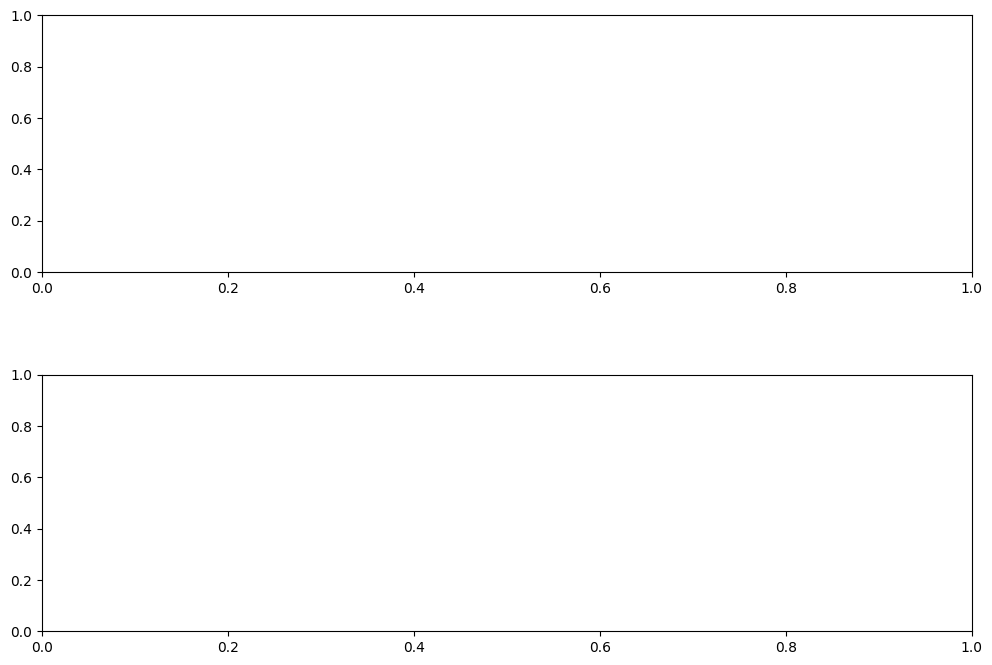

<Figure size 640x480 with 0 Axes>

Emotion: joyfully   Sentiment: Positive   Confidence: 0.51

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Emotion: sad        Sentiment: Negative   Confidence: 0.56

<Figure size 640x480 with 0 Axes>

Emotion: euphoric   Sentiment: Positive   Confidence: 0.48

<Figure size 640x480 with 0 Axes>

Emotion: euphoric   Sentiment: Positive   Confidence: 0.83

<Figure size 640x480 with 0 Axes>

Emotion: sad        Sentiment: Negative   Confidence: 0.58

<Figure size 640x480 with 0 Axes>

Emotion: joyfully   Sentiment: Positive   Confidence: 0.76

<Figure size 640x480 with 0 Axes>

Emotion: euphoric   Sentiment: Positive   Confidence: 0.97

<Figure size 640x480 with 0 Axes>

Emotion: euphoric   Sentiment: Positive   Confidence: 0.70

<Figure size 640x480 with 0 Axes>

Emotion: joyfully   Sentiment: Positive   Confidence: 0.98

<Figure size 640x480 with 0 Axes>

Emotion: euphoric   Sentiment: Positive   Confidence: 0.64

<Figure size 640x480 with 0 Axes>

Emotion: sad        Sentiment: Negative   Confidence: 1.00

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Emotion: euphoric   Sentiment: Positive   Confidence: 0.98
Stopped by user


In [5]:
realtime_sentiment_analysis()

Recording 5 seconds of audio...
Playing back raw recording...
Original audio saved to: C:\Users\Ayush\AppData\Local\Temp\tmp9z1wp_0l.wav
Applying noise reduction...
Playing back processed audio...


Processed audio saved to: C:\Users\Ayush\AppData\Local\Temp\tmp1i3uii_a.wav
Applying noise reduction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


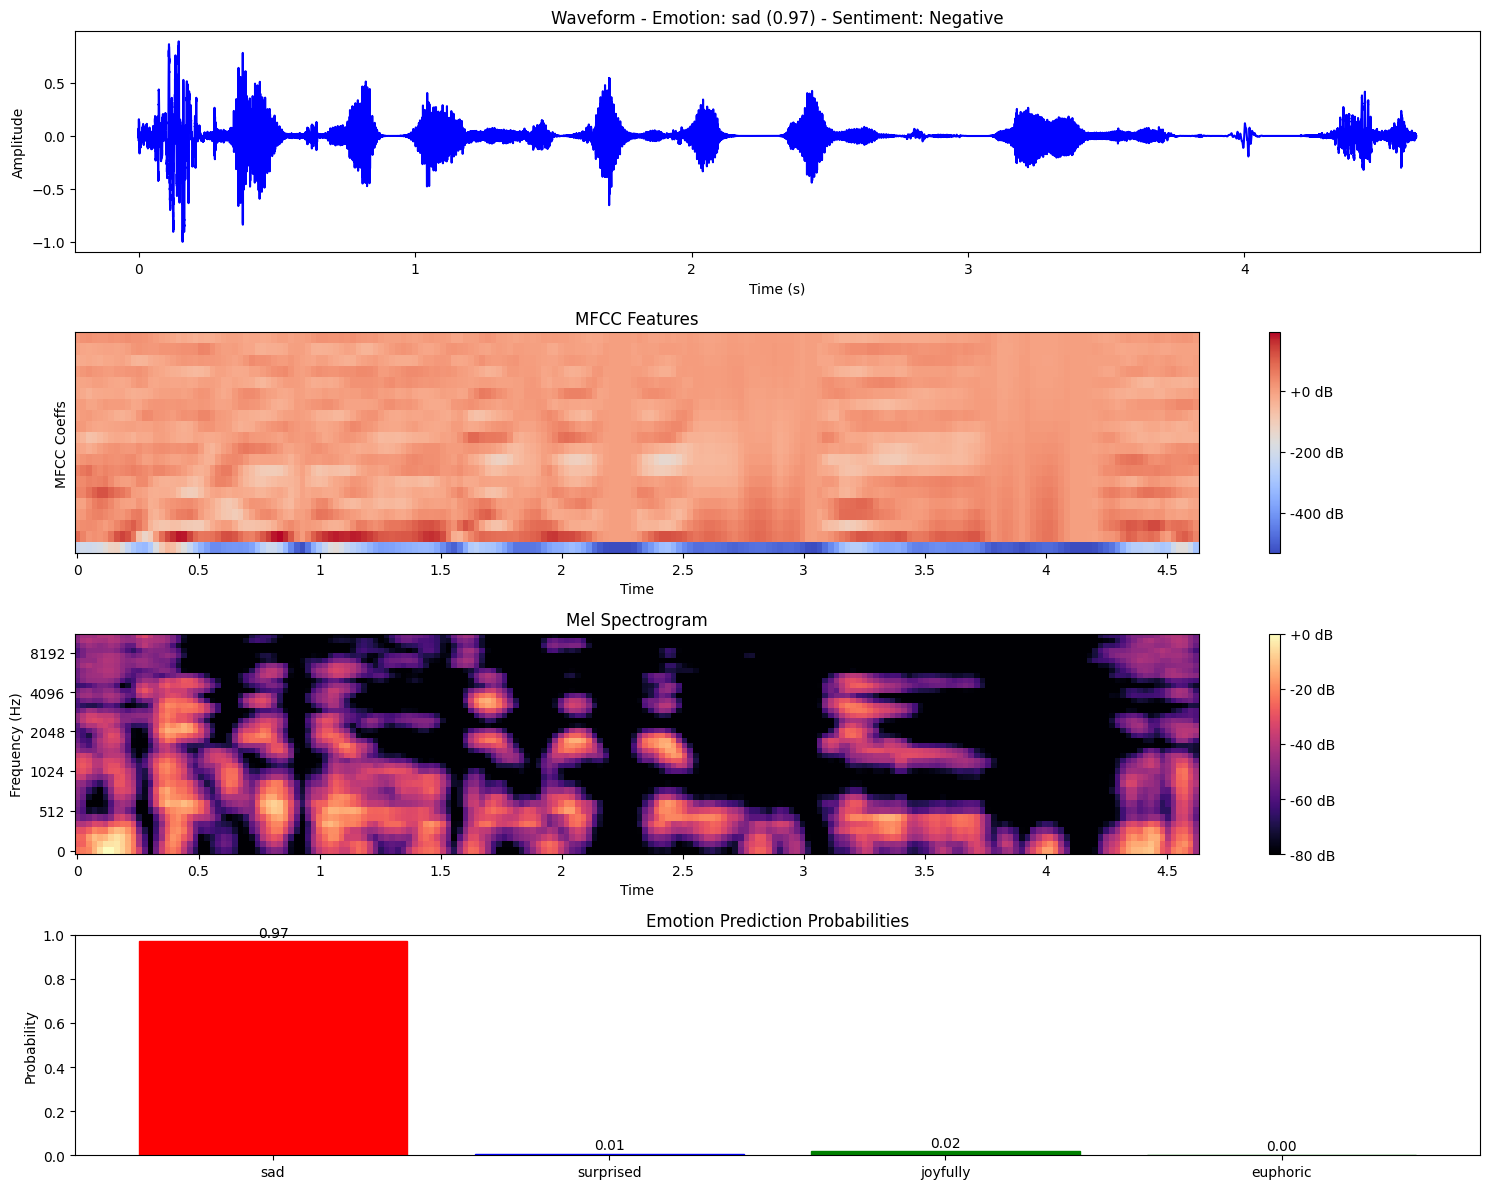

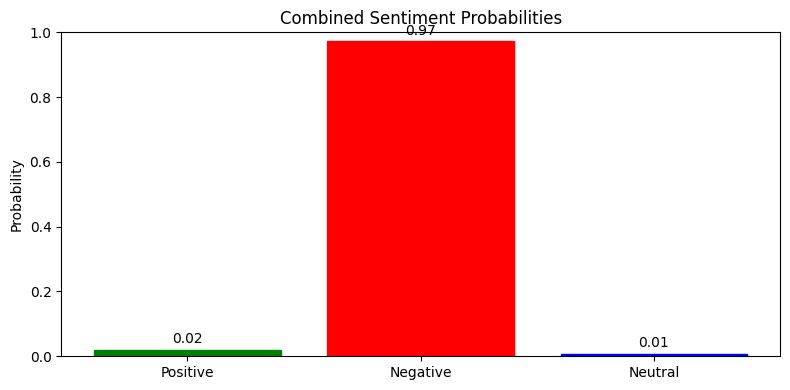

You can compare the original and processed files manually.
Original: C:\Users\Ayush\AppData\Local\Temp\tmp9z1wp_0l.wav
Processed: C:\Users\Ayush\AppData\Local\Temp\tmp1i3uii_a.wav


{'emotion': 'sad',
 'sentiment': 'Negative',
 'confidence': 0.971935510635376,
 'all_probs': {'sad': 0.971935510635376,
  'surprised': 0.007431970443576574,
  'joyfully': 0.01722969114780426,
  'euphoric': 0.0034029041416943073},
 'sentiment_probs': {'Positive': 0.020632595289498568,
  'Negative': 0.971935510635376,
  'Neutral': 0.007431970443576574}}

In [3]:
predict_sentiment_from_microphone()